*Problem 1.1*
Visulize Mandelbrot set.

### Mandelbrot Set

In [93]:
import numpy as np
import matplotlib.pyplot as plt
from scipy import stats
from time import time
from scipy.stats import norm
from scipy.stats import qmc
from mpl_toolkits.axes_grid1.inset_locator import inset_axes

In [94]:
def mandelbrot(c, z):
    return z**2 + c

def stability(c, max_iter = 200):
    z = 0
    for i in range(max_iter):
        z = mandelbrot(c, z)
        if abs(z) > 2:
            return i
    return max_iter

def mandelbrot_set(width, height, real_range, imag_range, max_iter = 200):
    real_vals = np.linspace(real_range[0], real_range[1], width)
    imag_vals = np.linspace(imag_range[0], imag_range[1], height)
    
    image = np.empty((width, height))
    for i in range(width):
        for j in range(height):
            image[i, j] = stability(real_vals[i] + 1j*imag_vals[j], max_iter)
    return image

# Compute the Mandelbrot set
resolution = 1000
max_iter = 200
width = resolution
height = resolution
real_range = [-2, 1]
imag_range = [-1.5, 1.5]
image = mandelbrot_set(width, height, real_range, imag_range, max_iter=max_iter)
    

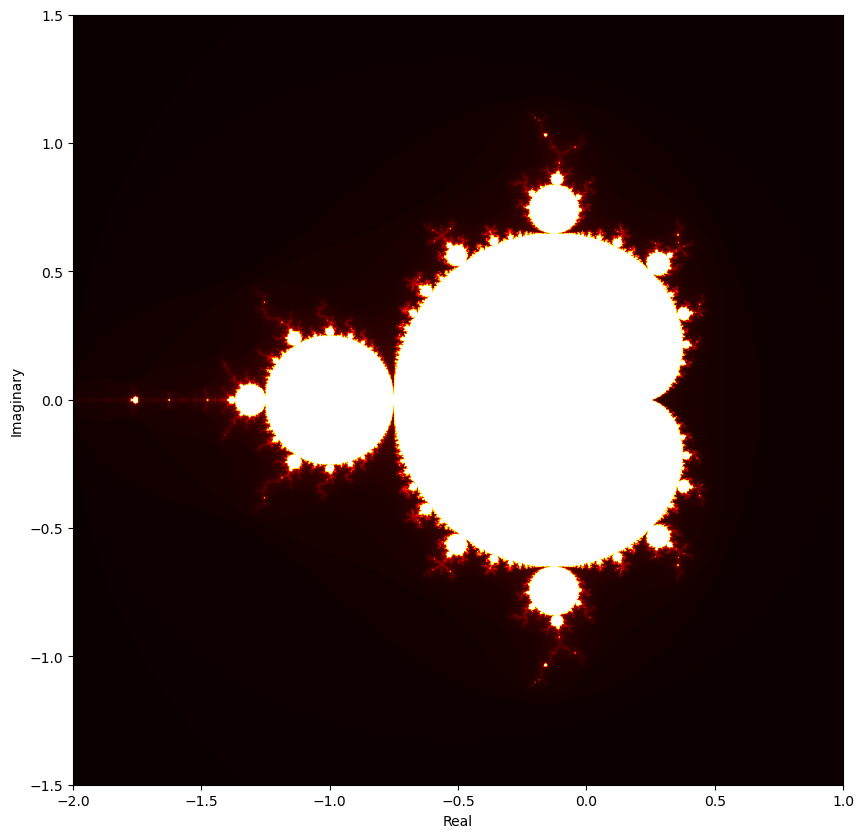

In [4]:
# Visualize with interpolation
plt.figure(figsize=(10, 10))
plt.imshow(image.T, cmap='hot', interpolation='bilinear', extent=[-2, 1, -1.5, 1.5])
plt.xlabel('Real')
plt.ylabel('Imaginary')
plt.show()

In [95]:
from scipy.interpolate import pchip_interpolate
from matplotlib.colors import LinearSegmentedColormap

def custom_colourmap():
    #set up the control points for your gradient
    yR_observed = [0, 0,32,237, 255, 0, 0, 32]
    yG_observed = [2, 7, 107, 255, 170, 2, 7, 107]
    yB_observed = [0, 100, 203, 255, 0, 0, 100, 203]

    x_observed = [-.1425, 0, .16, .42, .6425, .8575, 1, 1.16]

    #Create the arrays with the interpolated values
    x = np.linspace(min(x_observed), max(x_observed), num=1000)
    yR = pchip_interpolate(x_observed, yR_observed, x)
    yG = pchip_interpolate(x_observed, yG_observed, x)
    yB = pchip_interpolate(x_observed, yB_observed, x)

    #Convert them back to python lists
    x = list(x)
    yR = list(yR)
    yG = list(yG)
    yB = list(yB)

    #Find the indexs where x crosses 0 and crosses 1 for slicing
    start = 0
    end = 0
    for i in x:
        if i > 0:
            start = x.index(i)
            break

    for i in x:
        if i > 1:
            end = x.index(i)
            break

    #Slice away the helper data in the begining and end leaving just 0 to 1
    x = x[start:end]
    yR = yR[start:end]
    yG = yG[start:end]
    yB = yB[start:end]

    # Normalize the color values to the [0, 1] range
    yR = np.array(yR) / 255.0
    yG = np.array(yG) / 255.0
    yB = np.array(yB) / 255.0

    # Append 0 to the end of yR, yG, and yB
    yR = np.append(yR, 0.0)
    yG = np.append(yG, 0.0)
    yB = np.append(yB, 0.0)

    # Create a custom colormap from the interpolated color values
    colors = np.column_stack((yR, yG, yB))  # Combine R, G, and B values
    cmap = LinearSegmentedColormap.from_list('custom_colormap', colors, N=256)
    
    return cmap


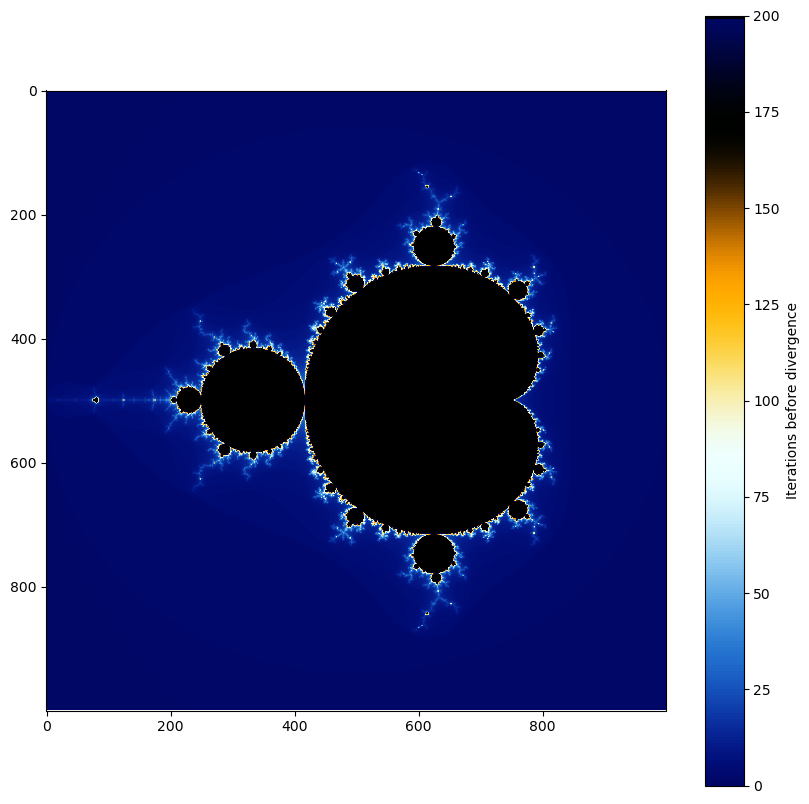

In [6]:
cmap = custom_colourmap()

# Create a figure and plot the data using the custom colormap
plt.figure(figsize=(10, 10))
plt.imshow(image.T, cmap=cmap)
plt.colorbar().set_label('Iterations before divergence')
plt.show()

## Question 2

Analyze how $i$ influence $A_{is}$ when $s$ is 100000(very large). We define $A_m$ = $A_{is}$ where $i = 6000$, $s = 100000$.

In [98]:
# Define the pure random sampling function
def pure_random_sampling(num_samples, real_range, imag_range):
    real_samples = np.random.uniform(real_range[0], real_range[1], num_samples)
    imag_samples = np.random.uniform(imag_range[0], imag_range[1], num_samples)
    return real_samples + 1j * imag_samples

# Define a function to estimate the area of the Mandelbrot set using sampling
def estimate_area(samples, max_iter):
    inside_count = 0
    for c in samples:
        if stability(c, max_iter) == max_iter:
            inside_count += 1
    area = (real_range[1] - real_range[0]) * (imag_range[1] - imag_range[0]) * inside_count / num_samples
    return area

# Define a function to calculate the convergence of areas for different values of max_iter
def convergence_curve(samples, max_iter_range):
    areas = []
    times = []
    
    for max_iter in max_iter_range:
        start_time = time()
        area = estimate_area(samples, max_iter)
        times.append(time() - start_time)
        areas.append(area)
    
    return areas, times

In [99]:
# Set parameters for the area estimation
num_samples = 100000
max_iter_range_adjusted = np.arange(100, 6000, 100)
real_range = [-2, 1]
imag_range = [-1.5, 1.5]

# Run the pure random sampling once and store the samples
pure_random_samples = pure_random_sampling(num_samples, real_range, imag_range)

# Calculate the convergence curve for pure random sampling with adjusted range
areas_pure_random, times_pure_random = convergence_curve(
    pure_random_samples,
    max_iter_range_adjusted
)


### Find the smallest i that meets the desired_relative_error(0.1%)

In [104]:
desired_relative_error = 0.001  # 0.1% relative error
# Initialize the minimum i and relative error
min_i = 1
min_i_index = 9999
min_i_relative_error = None
Am =  areas_pure_random[-1] # make the biggest i and s combination the Am

# Find the minimum i that satisfies the desired relative error
for i, area in enumerate(areas_pure_random):
    relative_error = abs(area - Am) / Am
    print(f"i = {max_iter_range_adjusted[i]}, relative error = {relative_error*100}%")
    if relative_error <= desired_relative_error:
        min_i = max_iter_range_adjusted[i]
        min_i_index = i  # Save the index where the condition is met
        min_i_relative_error = relative_error
        break  # Stop the loop as we found the minimum i satisfying the condition


print(f"$A_m$ is {Am}")
print(f"The minimum i that satisfies the desired relative error of {desired_relative_error*100}% is {min_i}.")
print(f"The relative error achieved is {min_i_relative_error*100}%.")
print(areas_pure_random[min_i_index])


i = 100, relative error = 2.6238893195777977%
i = 200, relative error = 1.2761643508855665%
i = 300, relative error = 0.8587274136800103%
i = 400, relative error = 0.632118790625566%
i = 500, relative error = 0.5307412487327855%
i = 600, relative error = 0.4353270916572223%
i = 700, relative error = 0.35780308903334007%
i = 800, relative error = 0.2743157015922259%
i = 900, relative error = 0.25642554714055965%
i = 1000, relative error = 0.23257200787167617%
i = 1100, relative error = 0.2146818534200099%
i = 1200, relative error = 0.1789015445166774%
i = 1300, relative error = 0.1789015445166774%
i = 1400, relative error = 0.1669747748822283%
i = 1500, relative error = 0.14908462043056206%
i = 1600, relative error = 0.14908462043056206%
i = 1700, relative error = 0.14908462043056206%
i = 1800, relative error = 0.12523108116167858%
i = 1900, relative error = 0.1133043115272295%
i = 2000, relative error = 0.08945077225833134%
$A_m$ is 1.50921
The minimum i that satisfies the desired rela

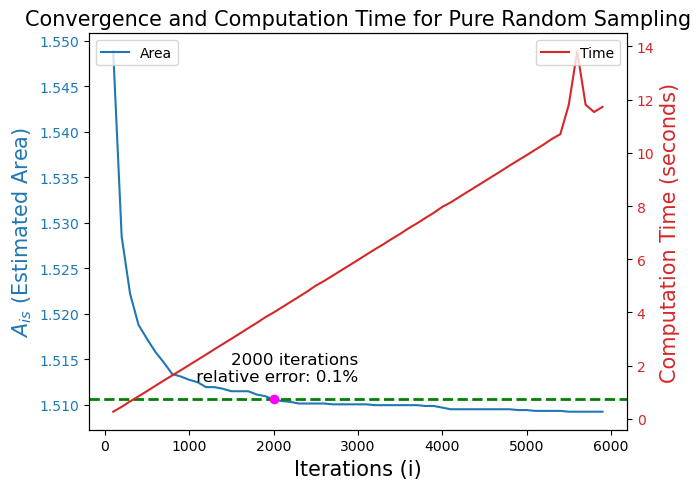

In [105]:
# Plotting
fig, ax1 = plt.subplots(figsize=(7, 5))

color = 'tab:blue'
ax1.set_xlabel('Iterations (i)', fontsize=15)
ax1.set_ylabel(r'$A_{is}$ (Estimated Area)', color=color, fontsize=15)
ax1.plot(max_iter_range_adjusted, areas_pure_random, label='Area', color=color)
ax1.tick_params(axis='y', labelcolor=color)
ax1.legend(loc='upper left')

ax2 = ax1.twinx()  # instantiate a second axes that shares the same x-axis
color = 'tab:red'
ax2.set_ylabel('Computation Time (seconds)', color=color, fontsize=15)
ax2.plot(max_iter_range_adjusted, times_pure_random, label='Time', color=color)
ax2.tick_params(axis='y', labelcolor=color)
ax2.legend(loc='upper right')

fig.tight_layout()  # otherwise the right y-label is slightly clipped
plt.title('Convergence and Computation Time for Pure Random Sampling', fontsize = 15)

# Add a horizontal line to indicate the minimum number of iterations to satisfy the desired relative error
ax1.axhline(y=areas_pure_random[min_i_index], color='green', linestyle='--', linewidth=2)

# Annotate the minimum number of iterations and relative error
relative_error_percent = min_i_relative_error * 100
# Add a magenta point to mark the minimum i
ax1.scatter(min_i, areas_pure_random[min_i_index], color='magenta', zorder=5)
# Add text annotation next to the point
ax1.annotate(f'{min_i} iterations\n relative error: {relative_error_percent:.1f}%', 
             xy=(min_i, areas_pure_random[min_i_index]), 
             xytext=(min_i + 1000, areas_pure_random[min_i_index] + 0.002), # slight offset for readability
             fontsize=12,
             horizontalalignment='right')
plt.tight_layout()

plt.savefig("2.1 Smallest i.jpg", dpi=300)
plt.show()


### Use i = min_iter to plot Ais and relative error upon different s
This i varies. Above is 2300, but for different runs, we can get different min_i.

In [106]:
# Define the parameters for the area estimation
num_samples_start = 1000
num_samples_max = 100000
max_iter = min_i
desired_d = 0.001
real_range = [-2, 1]
imag_range = [-1.5, 1.5]

# Initialize variables for the iterative process
num_samples = num_samples_start
Am_estimations = []
relative_errors = []
sample_sizes = []

# Main iterative process
while num_samples <= num_samples_max:
    # Generate samples and estimate area
    samples = pure_random_sampling(num_samples, real_range, imag_range)
    current_area = estimate_area(samples, max_iter)
    
    # Assume Am is the area estimated with the maximum number of samples
    if num_samples == num_samples_max:
        Am = current_area
    
    # Calculate relative error
    relative_error = abs(Am - current_area) / Am
    relative_errors.append(relative_error)
    Am_estimations.append(current_area)
    sample_sizes.append(num_samples)
    
    print(f"Number of samples: {num_samples}, Estimated Area: {current_area}, Relative Error: {relative_error}")
    
    # Update num_samples for next iteration
    num_samples += 1000

Number of samples: 1000, Estimated Area: 1.485, Relative Error: 0.01604150515832776
Number of samples: 2000, Estimated Area: 1.5255, Relative Error: 0.010793726519172374
Number of samples: 3000, Estimated Area: 1.395, Relative Error: 0.07567535333055037
Number of samples: 4000, Estimated Area: 1.5075, Relative Error: 0.001133043115272148
Number of samples: 5000, Estimated Area: 1.5264, Relative Error: 0.011390065000894534
Number of samples: 6000, Estimated Area: 1.4865, Relative Error: 0.015047607688790831
Number of samples: 7000, Estimated Area: 1.5132857142857143, Relative Error: 0.0027005614100850148
Number of samples: 8000, Estimated Area: 1.49175, Relative Error: 0.011568966545411197
Number of samples: 9000, Estimated Area: 1.507, Relative Error: 0.001464342271784606
Number of samples: 10000, Estimated Area: 1.476, Relative Error: 0.0220048899755501
Number of samples: 11000, Estimated Area: 1.5733636363636363, Relative Error: 0.04250809122894518
Number of samples: 12000, Estimated

In [107]:
print(max_iter)

2000


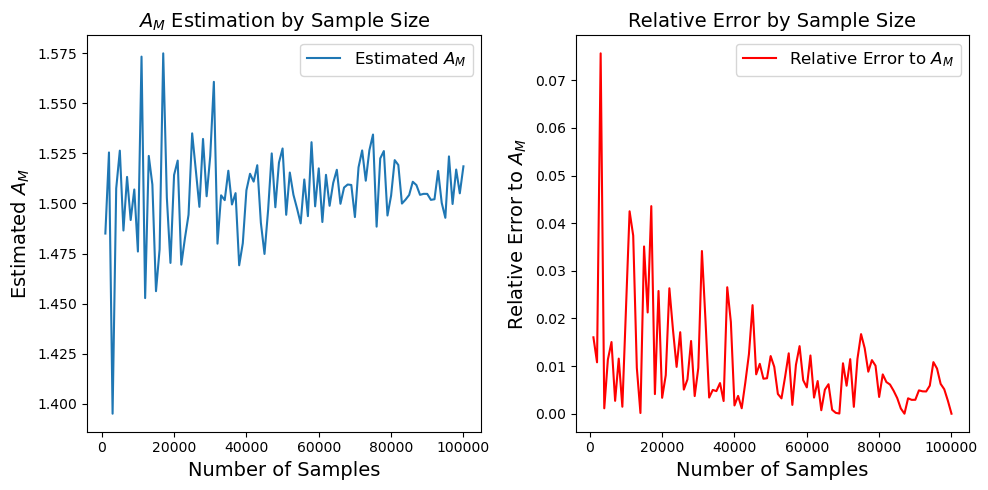

In [108]:
# Plotting the results
plt.figure(figsize=(10, 5))

# Plot Am estimations
plt.subplot(1, 2, 1)
plt.plot(sample_sizes, Am_estimations, label=r'Estimated $A_M$')
plt.xlabel('Number of Samples', fontsize=14)
plt.ylabel(r'Estimated $A_M$', fontsize=14)
plt.title(r'$A_M$ Estimation by Sample Size', fontsize=14)
plt.legend(fontsize = 12)



# Plot relative errors
plt.subplot(1, 2, 2)
plt.plot(sample_sizes, relative_errors, label=r'Relative Error to $A_M$', color='red')
plt.xlabel('Number of Samples',  fontsize=14)
plt.ylabel(r'Relative Error to $A_M$', fontsize=14)
plt.title('Relative Error by Sample Size', fontsize=14)
plt.legend(fontsize = 12)

plt.tight_layout()
plt.savefig("2.2 different s.jpg", dpi = 300)
plt.show()


Too much stochasticity.

### Find s using confidence interval(significance level = 95%)

In [109]:
# Set the range of sample sizes
sample_sizes = np.arange(1000, 500001, 1000)

# Calculate the estimated area and confidence intervals for each sample size
estimated_areas = []
conf_intervals = []

for s in sample_sizes:
    # Perform pure random sampling
    samples = pure_random_sampling(s, real_range, imag_range)
    # Estimate the area
    area = estimate_area(samples, 1900)
    estimated_areas.append(area)
    
    # Calculate the standard error using the sample's standard deviation
    # Assume std_dev is the sample standard deviation, which needs to be calculated from your data
    std_dev = np.std([stability(c, 1900) for c in samples], ddof=1)
    se = std_dev / np.sqrt(s)
    
    # Calculate the radius of the 95% confidence interval
    z_score = norm.ppf(0.975)  # 2.5% on each side to get 95% confidence interval
    conf_radius = z_score * se
    conf_intervals.append(conf_radius)

# Convert estimated areas and confidence intervals to numpy arrays
estimated_areas = np.array(estimated_areas)
conf_intervals = np.array(conf_intervals)

# Plot the estimated areas and confidence intervals
plt.figure(figsize=(12, 6))
plt.plot(sample_sizes, estimated_areas, label='Estimated Area', color='blue')
plt.fill_between(sample_sizes, estimated_areas - conf_intervals, estimated_areas + conf_intervals, color='gray', alpha=0.5, label='95% Confidence Interval')

# Set the chart title and labels
plt.title('Estimation of Mandelbrot Set Area with 95% Confidence Intervals')
plt.xlabel('Sample Size (s)', fontsize = 12)
plt.ylabel('Estimated Area of Mandelbrot Set', fontsize = 12)
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.savefig("Estimation of Mandelbrot Set(for each s do the sampling again).jpg", dpi = 300)
plt.show()



KeyboardInterrupt: 

#### The algorithm above takes too much time to run. So we change the algorithm to adding 1000 samples to the samples used before instead of making new samples every time.

In [110]:
# Define a area estimation function that takes in parameters of stabiliy[]
def estimate_area_from_stabilities(stabilities, total_samples, total_area, max_iter):
    # Count the number of samples that are considered to be within the Mandelbrot set
    inside_count = sum(stability == max_iter for stability in stabilities)

    # Calculate the estimated area based on the count of inside samples and total number of samples
    estimated_area = (total_area * inside_count) / total_samples

    return estimated_area

# Define a generic function that can calculate estimations and confidence intervals using any sampling method
def calculate_estimations(sampling_method, sample_sizes, real_range, imag_range, total_area, max_iter):
    estimated_areas = []
    conf_interval_radii = []
    all_stabilities = []

    for s in sample_sizes:
        if s == sample_sizes[0]:
            # For the first iteration, generate all samples and calculate stabilities
            all_samples = sampling_method(s, real_range, imag_range)
            all_stabilities = [stability(c, max_iter) for c in all_samples]
        else:
            # For subsequent iterations, only generate and calculate stabilities for additional samples
            additional_samples = sampling_method(1000, real_range, imag_range)
            additional_stabilities = [stability(c, max_iter) for c in additional_samples]
            all_stabilities.extend(additional_stabilities)

        # Calculate the area using the stabilities
        area = estimate_area_from_stabilities(all_stabilities, s, total_area, max_iter)
        estimated_areas.append(area)

        # Calculate the proportion of points within the Mandelbrot set
        p = area / total_area

        # Calculate the standard error of the proportion
        se = np.sqrt((p * (1 - p)) / s)

        # Convert the standard error to an area confidence interval width
        z_score = norm.ppf(0.975)  # Z-score for 95% confidence
        conf_radius = z_score * se * total_area
        conf_interval_radii.append(conf_radius)


    return np.array(sample_sizes), np.array(estimated_areas), np.array(conf_interval_radii)


In [111]:
# Example usage with pure_random_sampling as the sampling method
sample_sizes = np.arange(1000, 500001, 1000)
real_range = [-2, 1]
imag_range = [-1.5, 1.5]
# Calculate the total area of the complex plane region being considered 
total_area = (real_range[1] - real_range[0]) * (imag_range[1] - imag_range[0])

# Calculate estimations and confidence intervals
sample_sizes, estimated_areas, conf_interval_radii = calculate_estimations(
    pure_random_sampling, sample_sizes, real_range, imag_range, total_area, max_iter
)

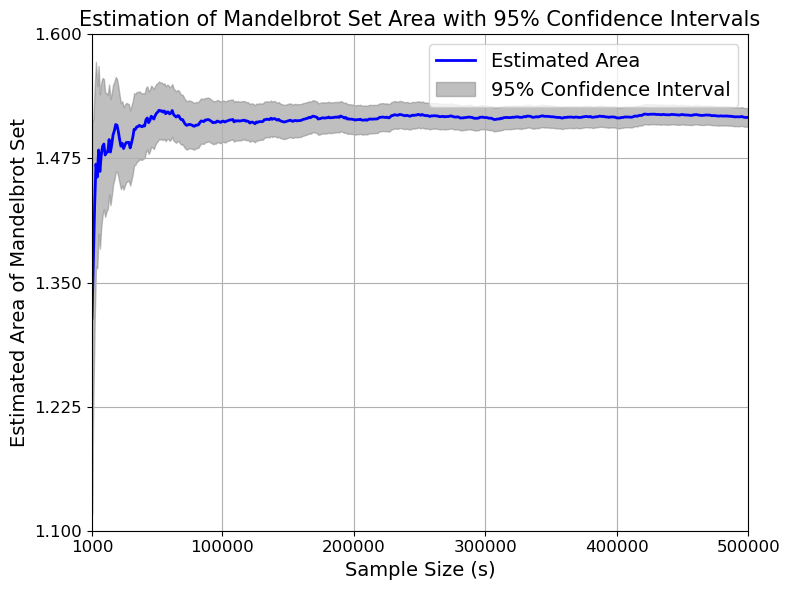

2000


In [112]:
# Plot the estimated area and confidence intervals
plt.figure(figsize=(8, 6))
plt.plot(sample_sizes, estimated_areas, label='Estimated Area', color='blue', linewidth=2)
plt.fill_between(sample_sizes, estimated_areas - conf_interval_radii, 
                 estimated_areas + conf_interval_radii, color='gray', alpha=0.5, 
                 label='95% Confidence Interval')

# Set chart title and labels with specified font sizes
plt.title('Estimation of Mandelbrot Set Area with 95% Confidence Intervals', fontsize=15)
plt.xlabel('Sample Size (s)', fontsize=14)
plt.ylabel('Estimated Area of Mandelbrot Set', fontsize=14)

# Specify font sizes for legend and grid
plt.legend(loc='upper right', fontsize=14)
plt.grid(True)

# Set the x and y axis limits to ensure the origin is shown
plt.xlim(left=sample_sizes[0], right=sample_sizes[-1])
plt.ylim(bottom=min(estimated_areas - conf_interval_radii), top=max(estimated_areas + conf_interval_radii))

# Customize the tick marks font size and set specific ticks on x-axis
ax = plt.gca()  # Get the current Axes instance
ax.set_xticks([sample_sizes[0]] + list(range(100000, sample_sizes[-1]+1, 100000)))  # Set specific x-ticks
ax.set_yticks(np.linspace(ax.get_yticks()[0], ax.get_yticks()[-1], num=5))  # Set y-ticks to be less dense

# Customize the tick labels font size
ax.tick_params(axis='x', labelsize=12)  # Smaller font size for x-ticks
ax.tick_params(axis='y', labelsize=12)

plt.tight_layout()
plt.savefig("2.3 confidence intervals.jpg", dpi=300)
plt.show()
print(max_iter)

#### Find the min s that meet our defination of accracy: 
- Relative error = confidence interval radius $/A_{is} < 1\%$
- significance level = $95\%$

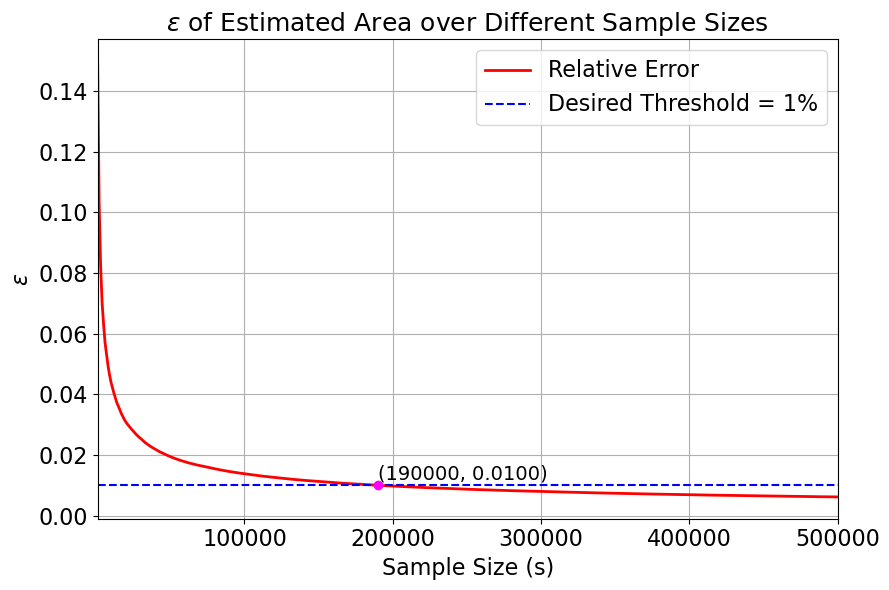

2000


In [114]:
def plot_relative_error_with_precomputed_data(sample_sizes, estimated_areas, conf_interval_radii, desired_relative_error_threshold):
    """
    Plot the relative errors of the estimated area using precomputed data and highlight the point
    where the relative error first falls below the desired threshold.
    
    :param sample_sizes: array-like, the range of sample sizes
    :param estimated_areas: array-like, precomputed estimated areas
    :param conf_interval_radii: array-like, precomputed confidence interval radii
    :param desired_relative_error_threshold: float, the desired relative error threshold
    """
    # Calculate relative errors from precomputed data
    relative_errors = conf_interval_radii / estimated_areas

    # Plot relative errors
    plt.figure(figsize=(9, 6))
    plt.plot(sample_sizes, relative_errors, label='Relative Error', color='red', linewidth=2)
    plt.axhline(y=desired_relative_error_threshold, color='blue', linestyle='--', label='Desired Threshold = 1%')

    # Find the smallest sample size that satisfies the desired relative error threshold
    satisfied_indices = np.where(relative_errors <= desired_relative_error_threshold)[0]
    if satisfied_indices.size > 0:
        min_satisfied_index = satisfied_indices[0]
        min_satisfied_sample_size = sample_sizes[min_satisfied_index]
        min_satisfied_error = relative_errors[min_satisfied_index]

        # Highlight the point with a magenta dot and annotate the coordinates
        plt.scatter(min_satisfied_sample_size, min_satisfied_error, color='magenta', zorder=5)
        plt.annotate(f'({min_satisfied_sample_size}, {min_satisfied_error:.4f})',
                     xy=(min_satisfied_sample_size, min_satisfied_error),
                     xytext=(min_satisfied_sample_size, min_satisfied_error + 0.002),
                     fontsize=14)

    plt.legend(fontsize=16)
    plt.xlabel('Sample Size (s)', fontsize=16)
    plt.ylabel(r'$\varepsilon$', fontsize=16)
    plt.title(r'$\varepsilon$ of Estimated Area over Different Sample Sizes', fontsize=18)
    plt.grid(True)
    plt.xlim(left=sample_sizes[0], right=sample_sizes[-1])
    plt.xticks(fontsize=16)
    plt.yticks(fontsize=16)
    plt.tight_layout()
    plt.savefig("2.4 radius analysis.jpg", dpi=300)
    plt.show()

# Use the precomputed data to plot the relative error
desired_relative_error = 0.01
plot_relative_error_with_precomputed_data(sample_sizes, estimated_areas, conf_interval_radii, desired_relative_error)
print(max_iter)



### Question 3: Use other sampling methods and run comparative analysis

In [115]:
def latin_hypercube_sampling(num_samples, real_range, imag_range):
    # Create a Latin Hypercube Sampler
    sampler = qmc.LatinHypercube(d = 2)  # We have two dimensions: real and imaginary
    sample = sampler.random(n = num_samples)
    # Scale the sample to the specified ranges
    real_samples = qmc.scale(sample[:, [0]], real_range[0], real_range[1])
    imag_samples = qmc.scale(sample[:, [1]], imag_range[0], imag_range[1])
    # Combine real and imaginary parts into a 1D array of complex numbers
    complex_samples = real_samples.flatten() + 1j * imag_samples.flatten()
    return complex_samples

def orthogonal_sampling(num_samples, real_range, imag_range):
    # Create an Orthogonal Sampler
    sampler = qmc.LatinHypercube(d = 2, strength = 2)
    sample = sampler.random(n = num_samples)
    # Scale the sample to the specified ranges
    real_samples = qmc.scale(sample[:, [0]], real_range[0], real_range[1])
    imag_samples = qmc.scale(sample[:, [1]], imag_range[0], imag_range[1])
    # Combine real and imaginary parts into a 1D array of complex numbers
    complex_samples = real_samples.flatten() + 1j * imag_samples.flatten()
    return complex_samples

def sieve_of_eratosthenes(n):
    """Return an array of prime numbers up to n."""
    sieve = np.ones(n + 1, dtype=bool)
    sieve[:2] = False  # 0 and 1 are not prime numbers
    for i in range(2, int(n ** 0.5) + 1):
        if sieve[i]:
            sieve[i*i:n+1:i] = False
    return np.nonzero(sieve)[0]


#### Plot the confidence interval of these 3 sampling methods. Compare the convergence.

In [116]:
# We need to use different calculate_estimations function for the 2 new methods 
# cuz samples have to be generated together for each run using these 2 new methods
# but not generate 1000 and add to the before one

def calculate_estimations_latin(sampling_method, sample_sizes, real_range, imag_range, total_area, max_iter):
    estimated_areas = []
    conf_interval_radii = []

    for s in sample_sizes:
        # Generate a new sample set for each sample size
        samples = sampling_method(s, real_range, imag_range)
        stabilities = [stability(c, max_iter) for c in samples]

        # Calculate the area using the stabilities
        area = estimate_area_from_stabilities(stabilities, s, total_area, max_iter)
        estimated_areas.append(area)

        # Calculate the proportion of points within the Mandelbrot set
        p = area / total_area

        # Calculate the standard error of the proportion
        se = np.sqrt((p * (1 - p)) / s)

        # Convert the standard error to an area confidence interval width
        z_score = norm.ppf(0.975)  # Z-score for 95% confidence
        conf_radius = z_score * se * total_area
        conf_interval_radii.append(conf_radius)

    return np.array(sample_sizes), np.array(estimated_areas), np.array(conf_interval_radii)


In [117]:
# Generate a large enough array of prime numbers since orthogonal_sampling only takes prime number's square as sample size
base_numbers = sieve_of_eratosthenes(150)  # Adjust the number here based on how many primes you need.107th prime number = 
# Square each number to get the sample sizes
sample_sizes = base_numbers**2

# Example usage with pure_random_sampling as the sampling method
real_range = [-2, 1]
imag_range = [-1.5, 1.5]
# Calculate the total area of the complex plane region being considered 
total_area = (real_range[1] - real_range[0]) * (imag_range[1] - imag_range[0])

# Calculate estimations and confidence intervals for pure random sampling
sample_sizes, estimated_areas_pure, conf_interval_radii_pure = calculate_estimations_latin(
    pure_random_sampling, sample_sizes, real_range, imag_range, total_area, max_iter
)

sample_sizes, estimated_areas_latin, conf_interval_radii_latin = calculate_estimations_latin(
    latin_hypercube_sampling, sample_sizes, real_range, imag_range, total_area, max_iter
)

sample_sizes, estimated_areas_ortho, conf_interval_radii_ortho = calculate_estimations_latin(
    orthogonal_sampling, sample_sizes, real_range, imag_range, total_area, max_iter
)

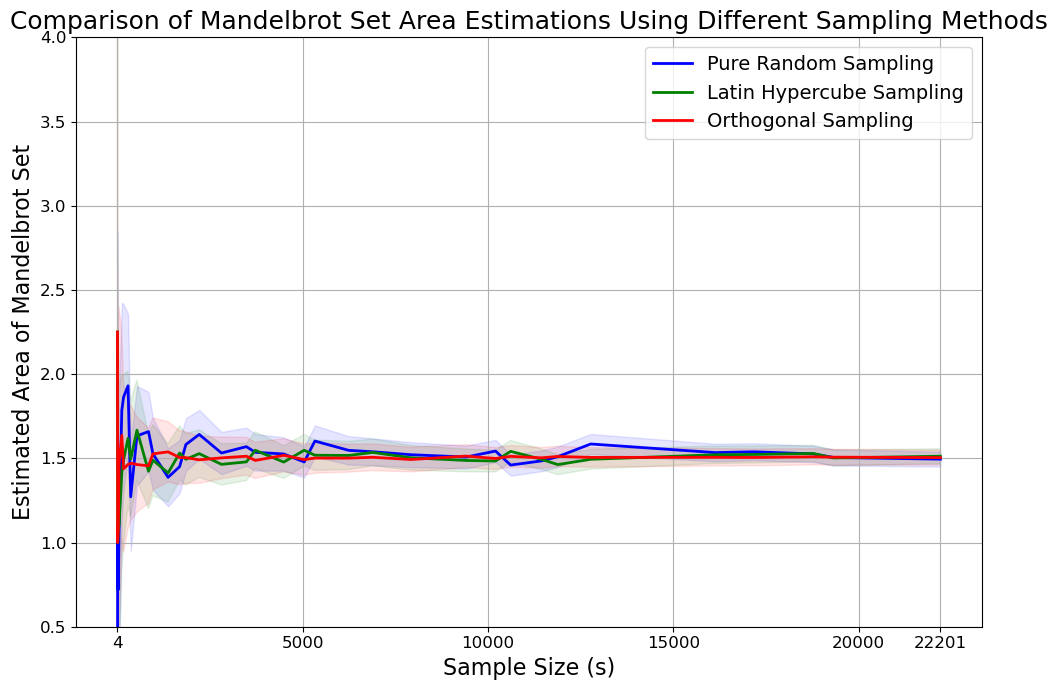

2000


In [118]:
# Plot the results for all three sampling methods on the same plot
plt.figure(figsize=(10, 7))

# Plot for Pure Random Sampling
plt.plot(sample_sizes, estimated_areas_pure, label='Pure Random Sampling', color='blue', linewidth=2)
plt.fill_between(sample_sizes, estimated_areas_pure - conf_interval_radii_pure, 
                 estimated_areas_pure + conf_interval_radii_pure, color='blue', alpha=0.1)

# Plot for Latin Hypercube Sampling
plt.plot(sample_sizes, estimated_areas_latin, label='Latin Hypercube Sampling', color='green', linewidth=2)
plt.fill_between(sample_sizes, estimated_areas_latin - conf_interval_radii_latin, 
                 estimated_areas_latin + conf_interval_radii_latin, color='green', alpha=0.1)

# Plot for Orthogonal Sampling
plt.plot(sample_sizes, estimated_areas_ortho, label='Orthogonal Sampling', color='red', linewidth=2)
plt.fill_between(sample_sizes, estimated_areas_ortho - conf_interval_radii_ortho, 
                 estimated_areas_ortho + conf_interval_radii_ortho, color='red', alpha=0.1)

# Set chart title and labels with specified font sizes
plt.title('Comparison of Mandelbrot Set Area Estimations Using Different Sampling Methods', fontsize=18)
plt.xlabel('Sample Size (s)', fontsize=16)
plt.ylabel('Estimated Area of Mandelbrot Set', fontsize=16)
plt.legend(loc='upper right', fontsize=14)
plt.grid(True)
xticks_values = [sample_sizes[0]] + list(range(5000, sample_sizes[-1], 5000)) + [sample_sizes[-1]]
plt.xticks(xticks_values, fontsize=12)
plt.yticks(fontsize=12)
plt.ylim(0.5,4)
plt.tight_layout()
plt.savefig("3.1 Ais complete.jpg", dpi=300)
plt.show()
print(max_iter)

In [61]:
print(estimated_areas_latin)
print(estimated_areas_ortho)
print(estimated_areas_pure)
print(base_numbers)
print(sample_sizes)

[2.25       1.         1.44       1.65306122 1.26446281 1.5443787
 1.71280277 1.47091413 1.463138   1.53032105 1.3673257  1.40029218
 1.42415229 1.57706869 1.54413762 1.49626201 1.51508187 1.51652782
 1.48563154 1.447927   1.51154063 1.5213908  1.53374946 1.50208307
 1.49888405 1.55102441 1.50240362 1.51401869 1.51275145 1.47662307
 1.53115506 1.4988637  1.52197773 1.49060608 1.49668934]
[4.5        1.         0.72       1.65306122 1.56198347 1.43786982
 1.52595156 1.49584488 1.48015123 1.5196195  1.52653486 1.53177502
 1.53123141 1.49432125 1.49524672 1.53150587 1.52542373 1.51652782
 1.51169526 1.49970244 1.50985175 1.51706457 1.50108869 1.50549173
 1.50844936 1.51132242 1.5066453  1.50615774 1.50669136 1.51327434
 1.51106702 1.5093526  1.50807182 1.50551214 1.50682402]
[2.25       2.         1.08       1.65306122 1.78512397 1.65088757
 1.6816609  1.69529086 1.53119093 1.6587396  1.55463059 1.56464573
 1.47769185 1.46511628 1.48709823 1.51228195 1.48147084 1.49959688
 1.52572956 1.39

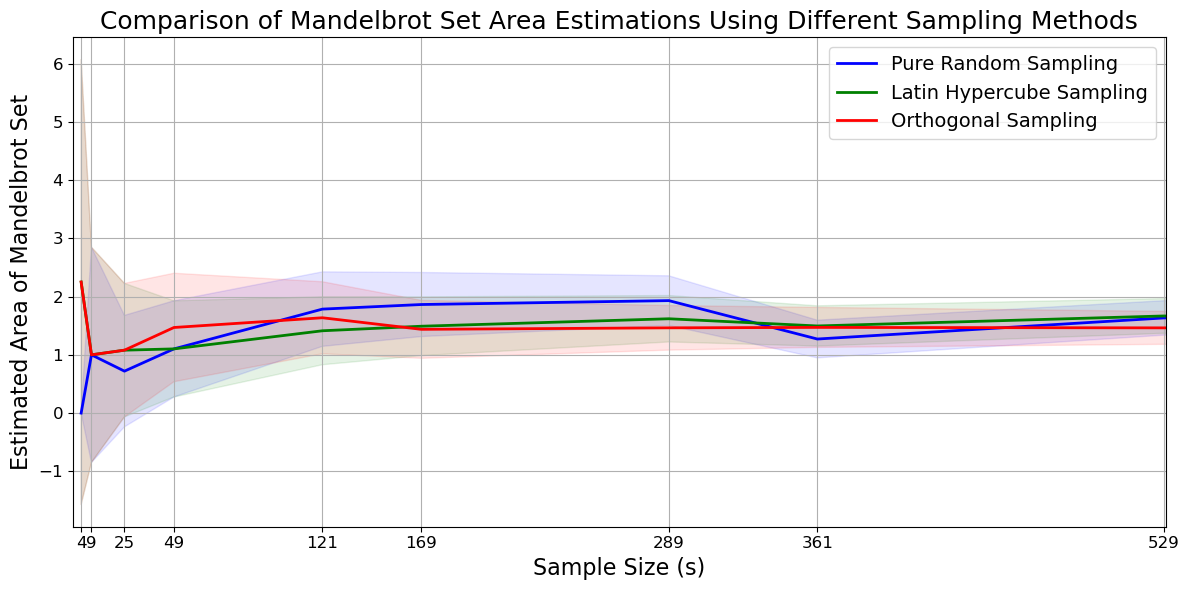

2000


In [119]:
plt.figure(figsize=(12, 6))

# Plot for Pure Random Sampling
plt.plot(sample_sizes, estimated_areas_pure, label='Pure Random Sampling', color='blue', linewidth=2)
plt.fill_between(sample_sizes, estimated_areas_pure - conf_interval_radii_pure, 
                 estimated_areas_pure + conf_interval_radii_pure, color='blue', alpha=0.1)

# Plot for Latin Hypercube Sampling
plt.plot(sample_sizes, estimated_areas_latin, label='Latin Hypercube Sampling', color='green', linewidth=2)
plt.fill_between(sample_sizes, estimated_areas_latin - conf_interval_radii_latin, 
                 estimated_areas_latin + conf_interval_radii_latin, color='green', alpha=0.1)

# Plot for Orthogonal Sampling
plt.plot(sample_sizes, estimated_areas_ortho, label='Orthogonal Sampling', color='red', linewidth=2)
plt.fill_between(sample_sizes, estimated_areas_ortho - conf_interval_radii_ortho, 
                 estimated_areas_ortho + conf_interval_radii_ortho, color='red', alpha=0.1)

# Set chart title and labels with specified font sizes
plt.title('Comparison of Mandelbrot Set Area Estimations Using Different Sampling Methods', fontsize=18)
plt.xlabel('Sample Size (s)', fontsize=16)
plt.ylabel('Estimated Area of Mandelbrot Set', fontsize=16)
plt.legend(loc='upper right', fontsize=14)
plt.grid(True)
xticks_values = sample_sizes[0:9]
plt.xticks(xticks_values, fontsize=12)
plt.yticks(fontsize=12)
plt.xlim(0,530)
plt.tight_layout()
plt.savefig("3.2 Ais part.jpg", dpi=300)
plt.show()
print(max_iter)

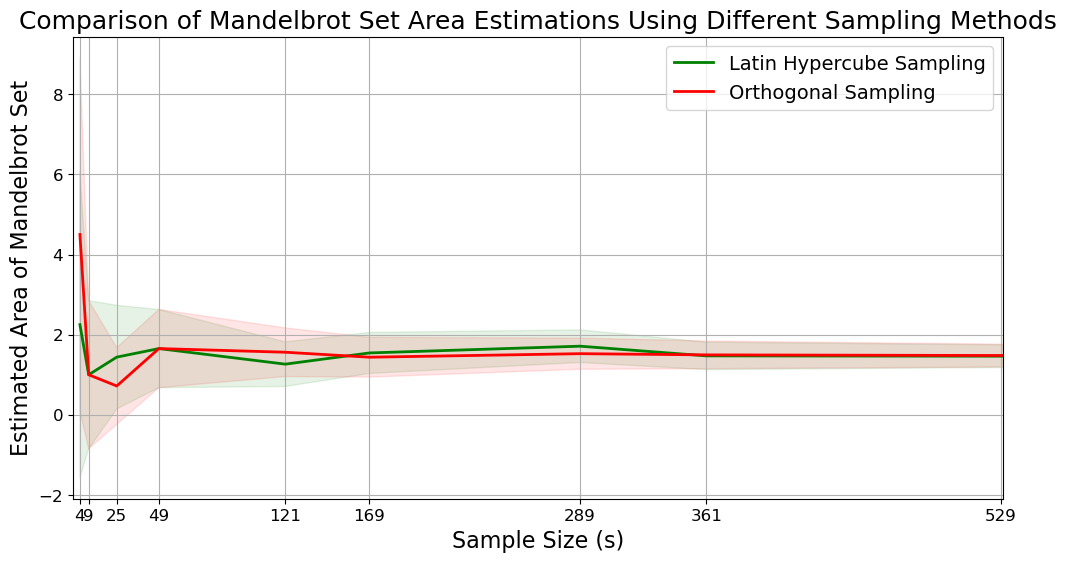

In [70]:
plt.figure(figsize=(12, 6))


# Plot for Latin Hypercube Sampling
plt.plot(sample_sizes, estimated_areas_latin, label='Latin Hypercube Sampling', color='green', linewidth=2)
plt.fill_between(sample_sizes, estimated_areas_latin - conf_interval_radii_latin, 
                 estimated_areas_latin + conf_interval_radii_latin, color='green', alpha=0.1)

# Plot for Orthogonal Sampling
plt.plot(sample_sizes, estimated_areas_ortho, label='Orthogonal Sampling', color='red', linewidth=2)
plt.fill_between(sample_sizes, estimated_areas_ortho - conf_interval_radii_ortho, 
                 estimated_areas_ortho + conf_interval_radii_ortho, color='red', alpha=0.1)

# Set chart title and labels with specified font sizes
plt.title('Comparison of Mandelbrot Set Area Estimations Using Different Sampling Methods', fontsize=18)
plt.xlabel('Sample Size (s)', fontsize=16)
plt.ylabel('Estimated Area of Mandelbrot Set', fontsize=16)
plt.legend(loc='upper right', fontsize=14)
plt.grid(True)
xticks_values = sample_sizes[0:9]
plt.xticks(xticks_values, fontsize=12)
plt.yticks(fontsize=12)
plt.xlim(0,530)

plt.show()

#### Plot the relative error using 3 methods. Compare the curve and the min s.

/var/folders/st/hfszkgw55n73h3v2jz7n8xth0000gn/T/ipykernel_61106/2358949984.py:16: RuntimeWarning: invalid value encountered in divide
  relative_errors = conf_interval_radii / estimated_areas


[       nan 1.84787177 1.32931225 0.74956389 0.35820831 0.29500075
 0.22060546 0.2543257  0.18097917 0.14218255 0.13989237 0.12409647
 0.10904083 0.09870302 0.08827883 0.08166377 0.07228449 0.07083198
 0.06474689 0.06226877 0.05768052 0.05444806 0.05199402 0.0488255
 0.04504663 0.04265909 0.04324366 0.0412076  0.04005181 0.03751309
 0.03404749 0.03294605 0.03165749 0.03146609 0.02947167]
[1.6973786  1.84787177 1.06152151 0.74956389 0.41283707 0.33832593
 0.24613403 0.23104795 0.17870876 0.15593403 0.14199564 0.12272415
 0.10557676 0.10215335 0.09222194 0.08389436 0.0749152  0.07049757
 0.06600411 0.06056984 0.05960014 0.05510043 0.05207403 0.04917952
 0.04541053 0.0436725  0.04185788 0.04106449 0.04081709 0.03887372
 0.03422019 0.03315069 0.03162758 0.03150122 0.0292673 ]
[1.6973786  1.84787177 1.06152151 0.63386531 0.37797377 0.34575385
 0.26161216 0.23338447 0.19340731 0.15387753 0.13989237 0.11666387
 0.10670262 0.10175617 0.0935777  0.0826026  0.07391242 0.07220735
 0.06495254 0.06

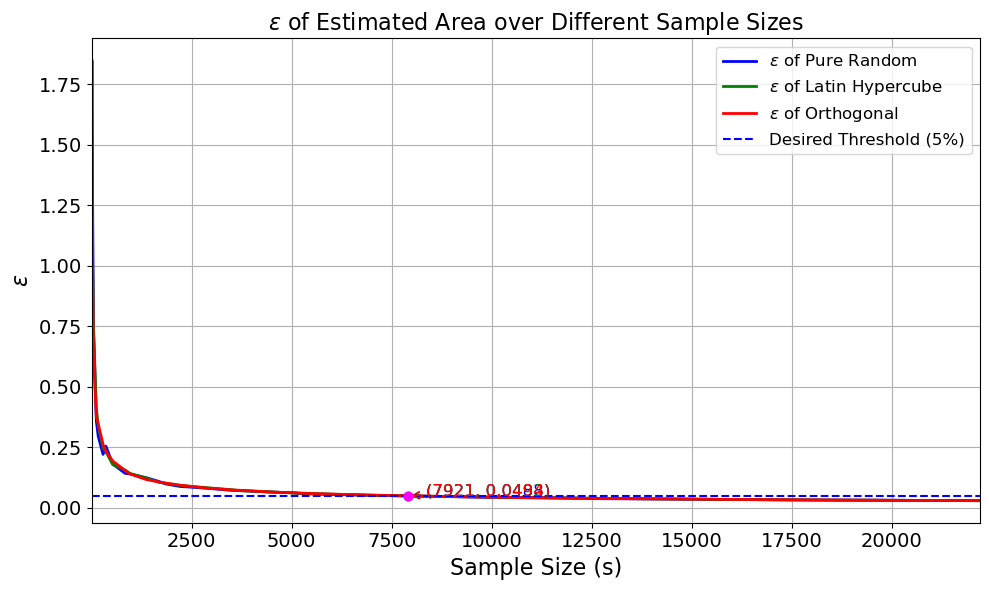

2000


In [120]:
def plot_relative_error_with_precomputed_data(sample_sizes, 
                                              estimated_areas_pure, conf_interval_radii_pure, 
                                              estimated_areas_latin, conf_interval_radii_latin, 
                                              estimated_areas_ortho, conf_interval_radii_ortho, 
                                              desired_relative_error_threshold):
    """
    Plot the relative errors of the estimated area using precomputed data for three sampling methods
    and highlight the point where the relative error first falls below the desired threshold.
    """
    # Set up the plot
    plt.figure(figsize=(10, 6))

    # Define a function to plot each method
    def plot_method(sample_sizes, estimated_areas, conf_interval_radii, label, color):
        # Calculate relative errors
        relative_errors = conf_interval_radii / estimated_areas
        print(relative_errors)
        plt.plot(sample_sizes, relative_errors, label=r'$\varepsilon$ of '+f'{label}', color=color, linewidth=2)

        # Find the smallest sample size that satisfies the desired relative error threshold
        satisfied_indices = np.where(relative_errors <= desired_relative_error_threshold)[0]
        if satisfied_indices.size > 0:
            min_satisfied_index = satisfied_indices[0]
            min_satisfied_sample_size = sample_sizes[min_satisfied_index]
            min_satisfied_error = relative_errors[min_satisfied_index]

            # Highlight the point with a magenta dot and annotate the coordinates
            plt.scatter(min_satisfied_sample_size, min_satisfied_error, color='magenta', zorder=5)
            plt.annotate(f'({min_satisfied_sample_size}, {min_satisfied_error:.4f})',
                         xy=(min_satisfied_sample_size, min_satisfied_error),
                         xytext=(min_satisfied_sample_size + 0.02 * sample_sizes[-1], 
                                 min_satisfied_error),
                         fontsize=12, color=color, arrowprops=dict(arrowstyle="->", color=color))

    # Plot each method
    plot_method(sample_sizes, estimated_areas_pure, conf_interval_radii_pure, 'Pure Random', 'blue')
    plot_method(sample_sizes, estimated_areas_latin, conf_interval_radii_latin, 'Latin Hypercube', 'green')
    plot_method(sample_sizes, estimated_areas_ortho, conf_interval_radii_ortho, 'Orthogonal', 'red')

    # Add horizontal line for the desired threshold
    plt.axhline(y=desired_relative_error_threshold, color='blue', linestyle='--', label='Desired Threshold (5%)')

    # Finalize the plot
    plt.legend(fontsize=12)
    plt.xlabel('Sample Size (s)', fontsize=16)
    plt.ylabel(r'$\varepsilon$', fontsize=16)
    plt.title(r'$\varepsilon$ of Estimated Area over Different Sample Sizes', fontsize=16)
    plt.grid(True)
    plt.xlim(left=sample_sizes[0], right=sample_sizes[-1])
    plt.xticks(fontsize=14)
    plt.yticks(fontsize=14)
    plt.tight_layout()
    plt.savefig("3.3 epsilon.jpg", dpi=300)
    plt.show()

# Example call to the function with precomputed data and a desired relative error threshold
desired_relative_error = 0.05  # 5% relative error
plot_relative_error_with_precomputed_data(sample_sizes, 
                                          estimated_areas_pure, conf_interval_radii_pure, 
                                          estimated_areas_latin, conf_interval_radii_latin, 
                                          estimated_areas_ortho, conf_interval_radii_ortho, 
                                          desired_relative_error)
print(max_iter)

From the figure above, we can see the confidence level for different sampling methods with same i and same s are quite similar. 
HAha! It proves... so little.
Now lets try the old fashioned way.

Now we define relative_error as Ais/Am to see how the sampling method influence the Ais.

[9.90207893e-01 3.31693633e-01 5.16077626e-01 2.64498300e-01
 1.85321695e-01 2.37200343e-01 2.81248706e-01 1.52927989e-01
 8.53239043e-02 1.02095785e-01 1.50370806e-02 7.67538535e-02
 3.47550194e-02 5.15196413e-02 9.10194595e-02 1.83105645e-02
 4.32489881e-02 2.11893112e-02 1.45067802e-02 1.67406709e-02
 6.52190719e-02 2.87429499e-02 2.32292076e-02 1.16549209e-02
 2.49763002e-03 2.59349331e-02 2.87857631e-02 1.23582173e-02
 3.96518035e-03 5.36473141e-02 1.99168085e-02 2.30621702e-02
 1.48780472e-02 8.86572666e-04 5.68443355e-03]
[4.91449192e-01 3.31693633e-01 2.79012492e-01 2.64498300e-01
 5.95803022e-02 8.28130389e-03 7.61750612e-02 5.17271160e-03
 1.07730817e-01 5.29408664e-02 9.63150769e-03 5.94371893e-02
 1.81298260e-02 6.17603750e-03 1.58969635e-02 2.59967317e-02
 1.63407826e-02 2.91530687e-02 1.71793593e-02 2.91110461e-02
 9.61175026e-03 8.80076189e-03 2.06482982e-02 3.16554065e-04
 1.07300451e-02 1.29910642e-02 2.48438269e-02 6.66401592e-03
 2.69624316e-02 6.22699521e-03 1.14654

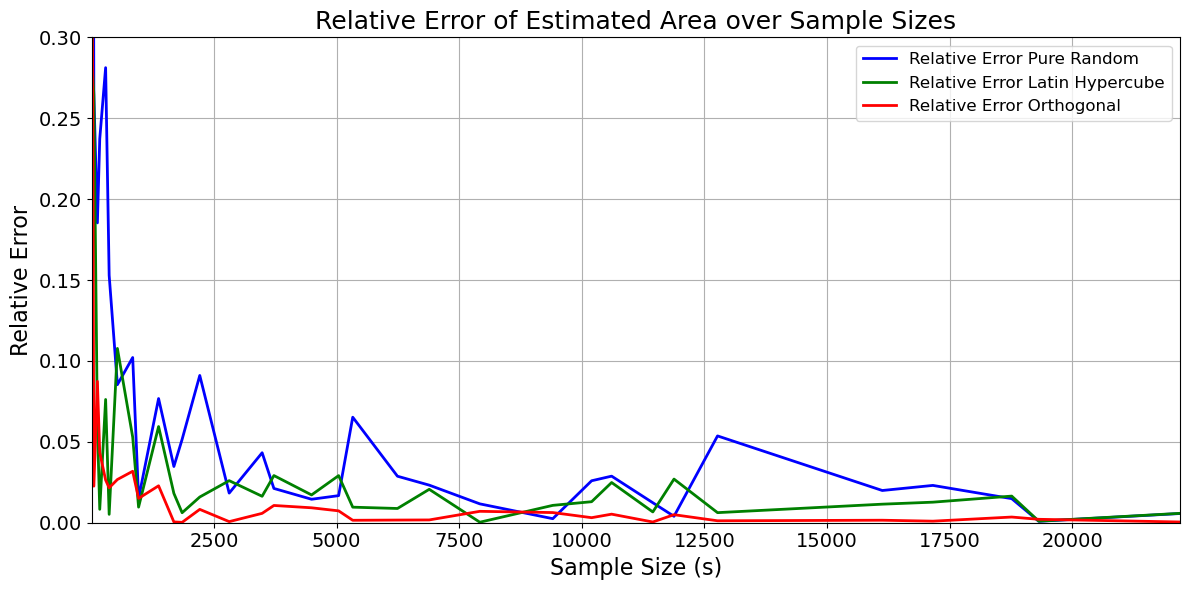

2000


In [122]:
def plot_relative_error_to_Am_with_precomputed_data(sample_sizes, 
                                              estimated_areas_pure, conf_interval_radii_pure, 
                                              estimated_areas_latin, conf_interval_radii_latin, 
                                              estimated_areas_ortho, conf_interval_radii_ortho, 
                                              desired_relative_error_threshold):
    """
    Plot the relative errors of the estimated area using precomputed data for three sampling methods
    and highlight the point where the relative error first falls below the desired threshold.
    """
    # Set up the plot
    plt.figure(figsize=(12, 6))

    # Define a function to plot each method
    def plot_method(sample_sizes, estimated_areas, conf_interval_radii, label, color):
        # Calculate relative errors
        relative_errors = abs(estimated_areas-1.5037)/Am
        print(relative_errors)
        plt.plot(sample_sizes, relative_errors, label=f'Relative Error {label}', color=color, linewidth=2)

        # Find the smallest sample size that satisfies the desired relative error threshold
        satisfied_indices = np.where(relative_errors <= desired_relative_error_threshold)[0]
        if satisfied_indices.size > 0:
            min_satisfied_index = satisfied_indices[0]
            min_satisfied_sample_size = sample_sizes[min_satisfied_index]
            min_satisfied_error = relative_errors[min_satisfied_index]

    # Plot each method
    plot_method(sample_sizes, estimated_areas_pure, conf_interval_radii_pure, 'Pure Random', 'blue')
    plot_method(sample_sizes, estimated_areas_latin, conf_interval_radii_latin, 'Latin Hypercube', 'green')
    plot_method(sample_sizes, estimated_areas_ortho, conf_interval_radii_ortho, 'Orthogonal', 'red')


    # Finalize the plot
    plt.legend(fontsize=12)
    plt.xlabel('Sample Size (s)', fontsize=16)
    plt.ylabel('Relative Error', fontsize=16)
    plt.title('Relative Error of Estimated Area over Sample Sizes', fontsize=18)
    plt.grid(True)
    plt.xlim(left=sample_sizes[0], right=sample_sizes[-1])
    plt.ylim(0, 0.3)
    plt.xticks(fontsize=14)
    plt.yticks(fontsize=14)
    plt.tight_layout()
    plt.savefig('3.5 relative error.jpg', dpi = 300)
    plt.show()

# Example call to the function with precomputed data and a desired relative error threshold
desired_relative_error = 0.05  # 5% relative error
plot_relative_error_to_Am_with_precomputed_data(sample_sizes, 
                                          estimated_areas_pure, conf_interval_radii_pure, 
                                          estimated_areas_latin, conf_interval_radii_latin, 
                                          estimated_areas_ortho, conf_interval_radii_ortho, 
                                          desired_relative_error)
print(max_iter)

Now we take each(i,s) combination for repetitions to simulate the variance and mean.

In [91]:
base_numbers = sieve_of_eratosthenes(150)
sample_sizes = base_numbers**2
# Lists to store mean error and standard deviation for each sample size and method
mean_errors_pure = []
mean_errors_latin = []
mean_errors_ortho = []
std_dev_pure = []
std_dev_latin = []
std_dev_ortho = []

# Iterate over each sample size
for s in sample_sizes:
    # Lists to store the errors for this sample size for each method
    errors_pure = []
    errors_latin = []
    errors_ortho = []
    
    # Perform the area estimation 10 times for each sample size
    for _ in range(10):
        # Pure Random Sampling
        samples_pure = pure_random_sampling(s, real_range, imag_range)
        area_pure = estimate_area(samples_pure, max_iter)
        errors_pure.append(abs(Am - area_pure)/Am)

        # Latin Hypercube Sampling
        samples_latin = latin_hypercube_sampling(s, real_range, imag_range)
        area_latin = estimate_area(samples_latin, max_iter)
        errors_latin.append(abs(Am - area_latin)/Am)

        # Orthogonal Sampling
        samples_ortho = orthogonal_sampling(s, real_range, imag_range)
        area_ortho = estimate_area(samples_ortho, max_iter)
        errors_ortho.append(abs(Am - area_ortho)/Am)
    
    # Calculate the mean error and standard deviation for this sample size for each method
    mean_errors_pure.append(np.mean(errors_pure))
    std_dev_pure.append(np.std(errors_pure))
    mean_errors_latin.append(np.mean(errors_latin))
    std_dev_latin.append(np.std(errors_latin))
    mean_errors_ortho.append(np.mean(errors_ortho))
    std_dev_ortho.append(np.std(errors_ortho))

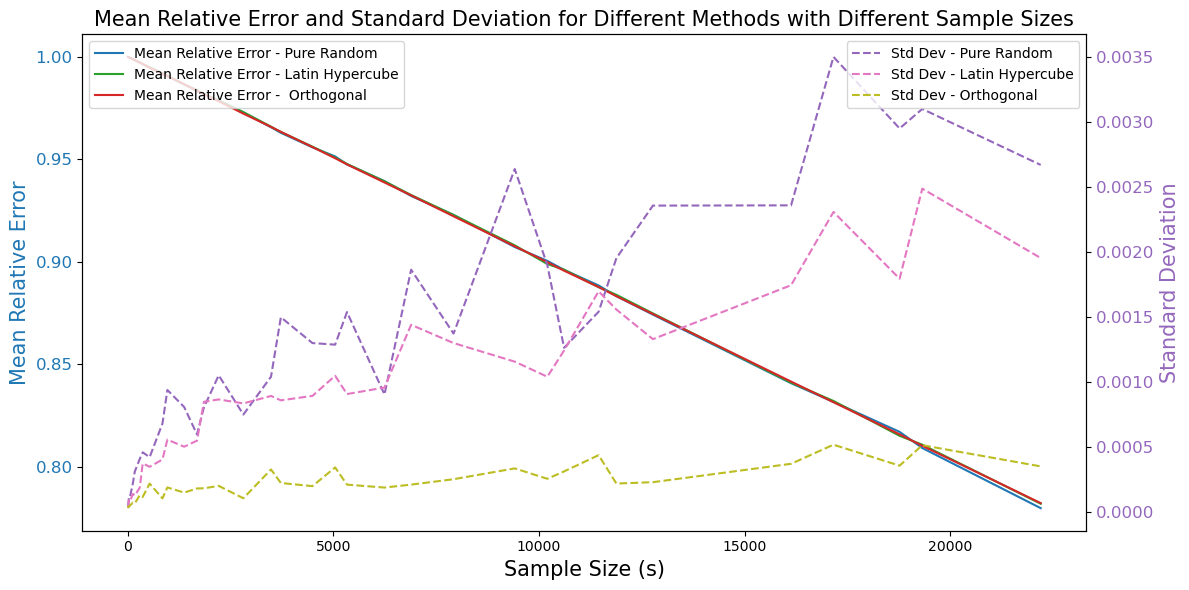

In [92]:
# Plotting the mean error and standard deviation
fig, ax1 = plt.subplots(figsize=(12, 6))

# Plot mean error
ax1.set_xlabel('Sample Size (s)', fontsize = 15)
ax1.set_ylabel('Mean Relative Error', color='tab:blue', fontsize = 15)
ax1.plot(sample_sizes, mean_errors_pure, label='Mean Relative Error - Pure Random', color='tab:blue')
ax1.plot(sample_sizes, mean_errors_latin, label='Mean Relative Error - Latin Hypercube', color='tab:green')
ax1.plot(sample_sizes, mean_errors_ortho, label='Mean Relative Error -  Orthogonal', color='tab:red')
ax1.tick_params(axis='y', labelcolor='tab:blue', labelsize = 12)

# Create a second y-axis for the standard deviation
ax2 = ax1.twinx()
ax2.set_ylabel('Standard Deviation', color='tab:purple',fontsize = 15)
ax2.plot(sample_sizes, std_dev_pure, label='Std Dev - Pure Random', color='tab:purple', linestyle='--')
ax2.plot(sample_sizes, std_dev_latin, label='Std Dev - Latin Hypercube', color='tab:pink', linestyle='--')
ax2.plot(sample_sizes, std_dev_ortho, label='Std Dev - Orthogonal', color='tab:olive', linestyle='--')
ax2.tick_params(axis='y', labelcolor='tab:purple', labelsize = 12)

ax1.legend(loc='upper left')
ax2.legend(loc='upper right')
plt.xticks(fontsize=12)

plt.title('Mean Relative Error and Standard Deviation for Different Methods with Different Sample Sizes', fontsize = 15)
plt.tight_layout()
plt.savefig('3.6 mean and standard deviation of relative error.jpg', dpi = 300)
plt.show()


In [128]:
# Algorithm implementation to find the minimum sample size s for d = 0.001
d = 0.001

def find_min_s(sampling_method, max_iter, d, real_range, imag_range):
    k = 1000  # Starting sample size
    while True:
        samples = sampling_method(k, real_range, imag_range)
        area_estimate = estimate_area(samples, max_iter)
        std_dev = np.std(samples, ddof=1)
        std_dev_of_mean = std_dev / np.sqrt(k)
        
        if std_dev_of_mean < d:
            return k  # This is the minimum sample size for the desired standard deviation
        
        k += 1000  # Increase sample size for the next iteration

# Compute the minimum sample size for each sampling method
min_s_pure_random = find_min_s(pure_random_sampling, max_iter, d, real_range, imag_range)
min_s_latin_hypercube = find_min_s(latin_hypercube_sampling, max_iter, d, real_range, imag_range)
min_s_orthogonal = find_min_s(orthogonal_sampling, max_iter, d, real_range, imag_range)

# Print the results
print("Minimum s for Pure Random:", min_s_pure_random)
print("Minimum s for Latin Hypercube:", min_s_latin_hypercube)
print("Minimum s for Orthogonal:", min_s_orthogonal)
